# Output normalization

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## calculate the per-level standard deviation

In this notebook, we will calculate the standard deviation of each target feature in the train_target.npy file, which you can get from the huggingface. See the subsampled (every 7th time step) version of low-resolution real-geography dataset.

In [2]:
climsim_path = '/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/'
grid_path = climsim_path+'/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = climsim_path+'/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')
xout = np.load('/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/preprocessing/v2_adv_noinf/train_target.npy')

# un-normalize targets to their original units
# the train_target.npy used above is following the offline part of the repo, where data is normalized before saving to .npy.
# you can skip the "/out_scale" part below if your saved data is un-normalized. 
yt = xout[:,0:60]/output_scale['ptend_t'].values
yq1 = xout[:,60:120]/output_scale['ptend_q0001'].values
yq2 = xout[:,120:180]/output_scale['ptend_q0002'].values
yq3 = xout[:,180:240]/output_scale['ptend_q0003'].values
yqn = yq2+yq3
yu = xout[:,240:300]/output_scale['ptend_u'].values
yv = xout[:,300:360]/output_scale['ptend_v'].values

In [3]:
# retrieve scalar targets in their original units
features = list(output_scale.data_vars.keys())
y2d = xout[:,360:368]
for i in range(8):
    y2d[:,i] = y2d[:,i]/output_scale[features[6+i]].values

In [4]:
# calculate per-level st.d.
yt_std = yt.std(axis=0)
yq1_std = yq1.std(axis=0)
yq2_std = yq2.std(axis=0)
yq3_std = yq3.std(axis=0)
yqn_std = yqn.std(axis=0)
yu_std = yu.std(axis=0)
yv_std = yv.std(axis=0)
y2d_std = y2d.std(axis=0)

## below are the visualization of the st.d. vertical distribution of each variable

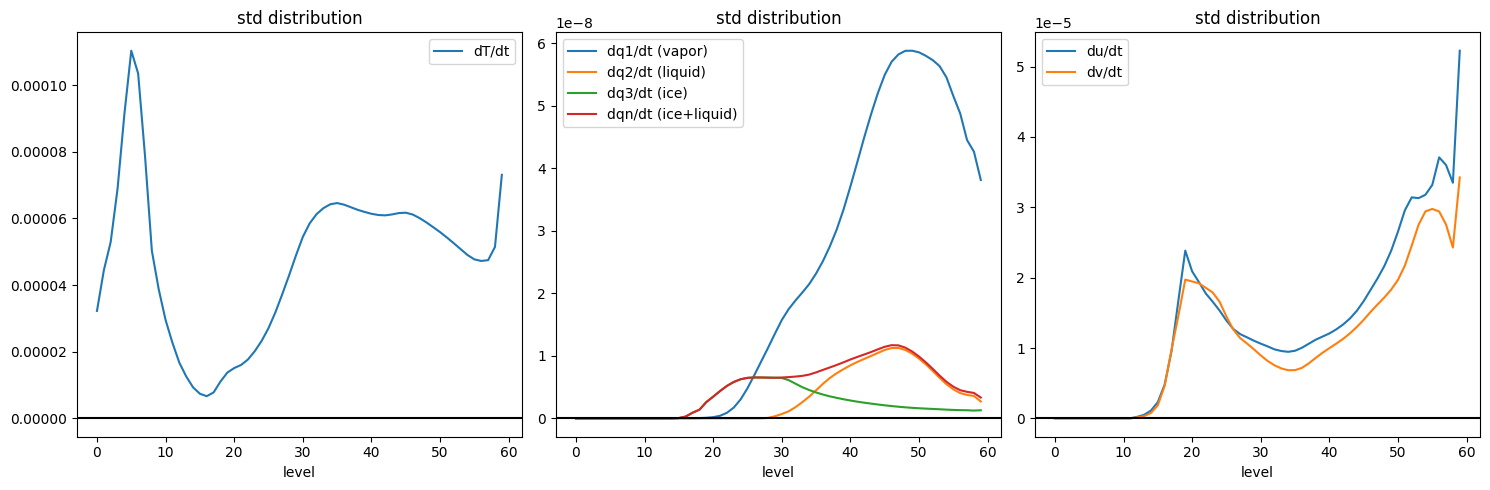

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].plot(yt_std, label='dT/dt')
axs[0].axhline(0, color="black")
axs[0].legend()
axs[0].set_title('std distribution')
axs[0].set_xlabel('level')

# Second subplot
axs[1].plot(yq1_std, label='dq1/dt (vapor)')
axs[1].plot(yq2_std, label='dq2/dt (liquid)')
axs[1].plot(yq3_std, label='dq3/dt (ice)')
axs[1].plot(yqn_std, label='dqn/dt (ice+liquid)')
axs[1].axhline(0, color="black")
axs[1].legend()
axs[1].set_title('std distribution')
axs[1].set_xlabel('level')

# Third subplot
axs[2].plot(yu_std, label='du/dt')
axs[2].plot(yv_std, label='dv/dt')
axs[2].axhline(0, color="black")
axs[2].legend()
axs[2].set_title('std distribution')
axs[2].set_xlabel('level')

# Adjust layout
plt.tight_layout()
plt.show()


As you can see from the st.d. distribution above, for vapor, cloud, and u/v winds, their st.d. decrease dramatically in the upper atmosphere, and their st.d are exactly 0 in the upper 12 levels. In order to avoid normalizing y as y/std with std being very tiny value, we try to add a threshold: y' = y/max(std, threshold). Different variables have different threshold vaues. The larger the threshold is, the more upper levels are penalized in the total loss function. Below we saved two version of the output scaling file, one apply a threshold only that is only larger than std in the top 12 levels, the other apply a threshold that penalize more upper levels. 

### A tiny threshold version that only previous 0-std in the top 12 levels

In [16]:
yt_std_thres = yt_std
yq1_std_thres = np.where(yq1_std<1e-12, 1e-12, yq1_std)
yq2_std_thres = np.where(yq2_std<1e-12, 1e-12, yq2_std)
yq3_std_thres = np.where(yq3_std<1e-12, 1e-12, yq3_std)
yqn_std_thres = np.where(yqn_std<1e-12, 1e-12, yqn_std)
yu_std_thres = np.where(yu_std<2e-7, 2e-7, yu_std)
yv_std_thres = np.where(yv_std<2e-7, 2e-7, yv_std)

output_scale_std = output_scale.copy()
output_scale_std['ptend_t'][:] = 1./yt_std_thres
output_scale_std['ptend_q0001'][:] = 1./yq1_std_thres
output_scale_std['ptend_q0002'][:] = 1./yq2_std_thres
output_scale_std['ptend_q0003'][:] = 1./yq3_std_thres
output_scale_std['ptend_u'][:] = 1./yu_std_thres
output_scale_std['ptend_v'][:] = 1./yv_std_thres
for i in range(8):
    output_scale_std[features[6+i]] = 1/y2d_std[i]

ptend_qn_value = 1. / yqn_std_thres
output_scale_std['ptend_qn'] = xr.DataArray(ptend_qn_value, dims=['lev'], coords={'lev': output_scale_std['lev']})
climsim_path = '/global/u2/z/zeyuanhu/nvidia_codes/climsim_tests'
norm_path = climsim_path+'/normalization/'
output_scale_std.to_netcdf(norm_path + 'outputs/output_scale_std_nopenalty.nc')

### Another threshold version that underweights a few more upper atmosphere levels

In [17]:
yt_std_thres = yt_std 
yq1_std_thres = np.where(yq1_std<3e-10, 3e-10, yq1_std)
yq2_std_thres = np.where(yq2_std<3e-10, 3e-10, yq2_std)
yq3_std_thres = np.where(yq3_std<3e-10, 3e-10, yq3_std)
yqn_std_thres = np.where(yqn_std<3e-10, 3e-10, yqn_std)
yu_std_thres = np.where(yu_std<1e-6, 1e-6, yu_std)
yv_std_thres = np.where(yv_std<1e-6, 1e-6, yv_std)

output_scale_std = output_scale.copy()
output_scale_std['ptend_t'][:] = 1./yt_std_thres
output_scale_std['ptend_q0001'][:] = 1./yq1_std_thres
output_scale_std['ptend_q0002'][:] = 1./yq2_std_thres
output_scale_std['ptend_q0003'][:] = 1./yq3_std_thres
output_scale_std['ptend_u'][:] = 1./yu_std_thres
output_scale_std['ptend_v'][:] = 1./yv_std_thres
for i in range(8):
    output_scale_std[features[6+i]] = 1/y2d_std[i]

ptend_qn_value = 1. / yqn_std_thres
output_scale_std['ptend_qn'] = xr.DataArray(ptend_qn_value, dims=['lev'], coords={'lev': output_scale_std['lev']})
climsim_path = '/global/u2/z/zeyuanhu/nvidia_codes/climsim_tests'
norm_path = climsim_path+'/normalization/'
output_scale_std.to_netcdf(norm_path + 'outputs/output_scale_std_lowerthred_v5.nc')

The horizonal grey line in each plot shows the threshold value in y' = y/max(std, threshold)

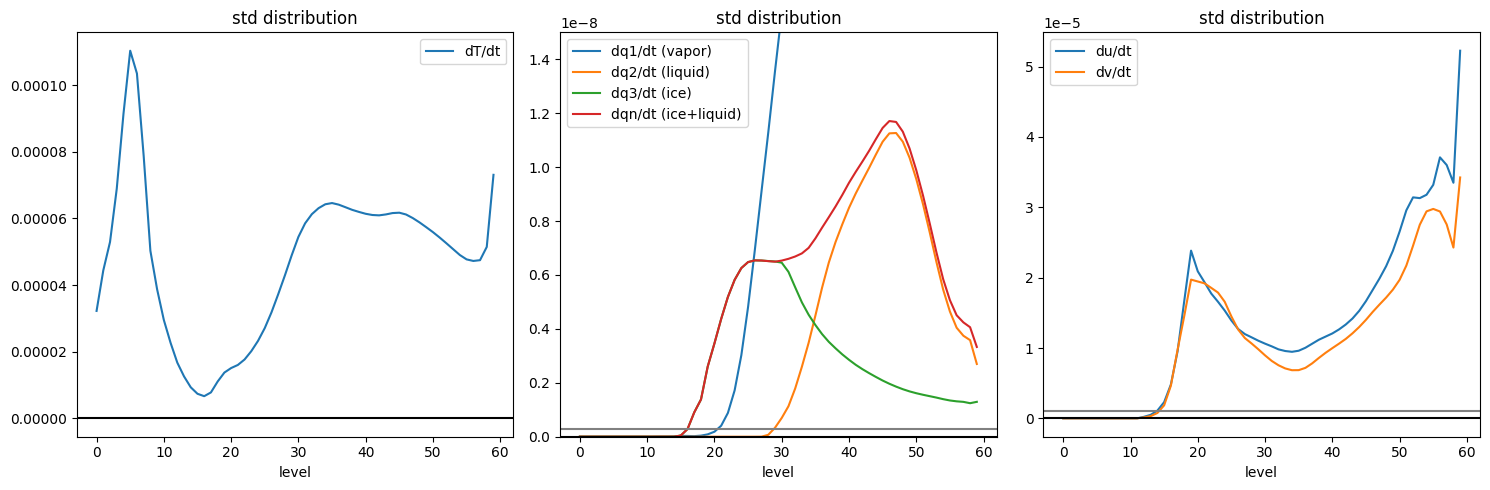

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].plot(yt_std, label='dT/dt')
axs[0].axhline(0, color="black")
axs[0].legend()
axs[0].set_title('std distribution')
axs[0].set_xlabel('level')

# Second subplot
axs[1].plot(yq1_std, label='dq1/dt (vapor)')
axs[1].plot(yq2_std, label='dq2/dt (liquid)')
axs[1].plot(yq3_std, label='dq3/dt (ice)')
axs[1].plot(yqn_std, label='dqn/dt (ice+liquid)')
axs[1].axhline(0, color="black")
axs[1].axhline(3e-10, color="grey")
axs[1].legend()
axs[1].set_ylim(0,1.5e-8)
axs[1].set_title('std distribution')
axs[1].set_xlabel('level')

# Third subplot
axs[2].plot(yu_std, label='du/dt')
axs[2].plot(yv_std, label='dv/dt')
axs[2].axhline(0, color="black")
axs[2].axhline(1e-6, color="grey")
axs[2].legend()
axs[2].set_title('std distribution')
axs[2].set_xlabel('level')

# Adjust layout
plt.tight_layout()
plt.show()
